# Example: Extrinsic calibration of 15 GoPro cameras

Suppose we have 15 GoPro cameras capturing a target.  This example demonstrates how to calibrate these cameras into a unified world coordinate system.  The steps include:

1. Intrinsic calibration
2. 2D corresponding points detection
3. Extrinsic calibration
   1. Linear calibration (intial guess)
   2. Non-linear optimization (bundle adjustment)
4. (optional) Scale / orientation adjustment

## Step 2: 2D keypoint detection from ChAruCo markers

Let each camera capture a "calibration target" having [ChAruCo](https://docs.opencv.org/4.10.0/df/d4a/tutorial_charuco_detection.html) patterns on it.  In this example, we use a half dodecahedron each face of which has a ChAruCo pattern (a PDF to print this can be found at [here](../data/ba/kp_12.pdf)).

![Calibration target](../data/ba/kp.jpg)

Capture this object at diffrent positions and save them as `camera_{CAMID:02d}_{POSID:04d}.{jpg|png}`.  The code below detects the ChAruCo patterns from these images, and saves the detected 2D positions as `output-kp.txt.bz2` in [BAL format](https://grail.cs.washington.edu/projects/bal/).  Notice that the camera intrinsics and 3D point positions in this file are filled with zeros as placeholders.

- If your image filenames do not follow the naming convention above, update the `parse_filename()` function to extract the camera and the position IDs from the filenames.

### 2-1: Target boards

Before detecting the ChAruCo patterns from the images, double-check that the patterns to be detected are identical to those printed on the calibration target.

This cell prepares `BOARD_COUNT` ChAruCo detectors and visualizes the patterns they try to detect.

- The size of the chess pattern, i.e., the number of _cells_, is defined by `BOARD_ROWS` and `BOARD_COLS`.  The number of _chess corners_ is `(BOARD_ROWS-1) * (BOARD_COLS-1)`.


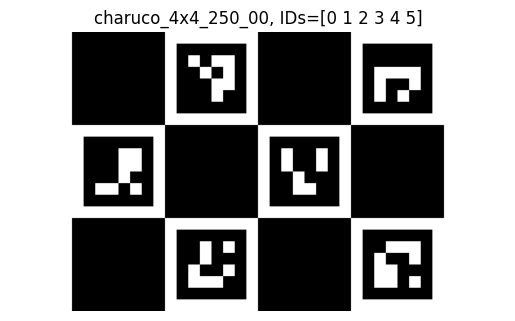

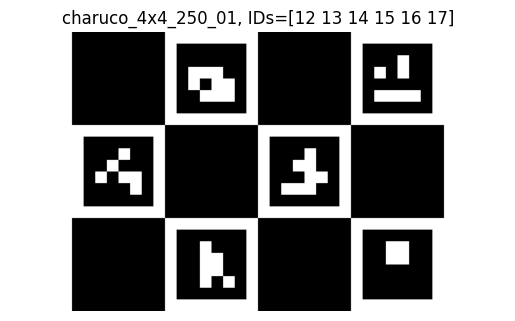

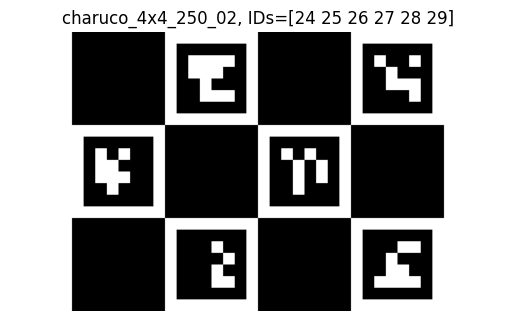

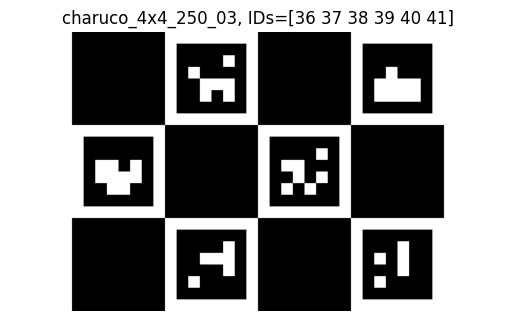

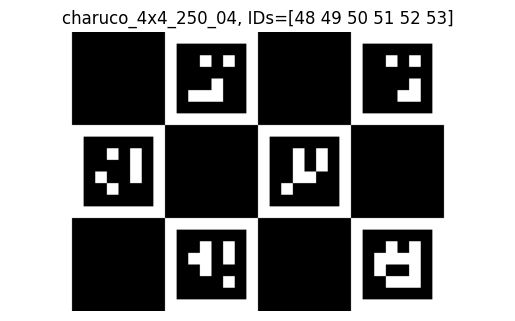

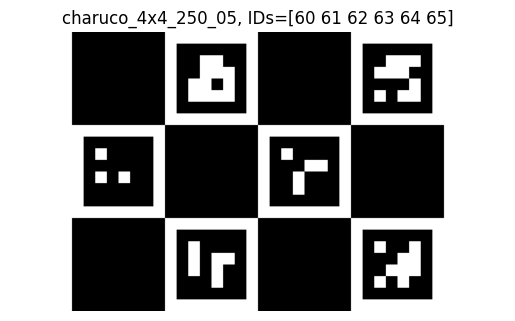

In [1]:
import numpy as np
import sys
import os
import json
import bz2
import cv2
import matplotlib.pyplot as plt
import glob
import re
import pandas as pd
import pycalib  # pip install pycalib-simple

# Input image files
INPUT_FILES = '../data/ba/kp/*.jpg'

# How to extract camera-id and position-id from an image filename 
def parse_filename(filename):
    # filename -> camera-id, position-id
    f = os.path.basename(filename)
    ret = re.match('camera_0*([0-9]+)_0*([0-9]+).((jpg)|(png))', f)
    if ret:
        return int(ret.group(1)), int(ret.group(2))
    else:
        return -1, -1

# Num of boards in the scene
BOARD_COUNT = 6

# Num of chesscorners in each board
BOARD_ROWS  = 3
BOARD_COLS  = 4

# AruCo marker ID increment between boards (min = num of AruCo markers in each board = ROWS*COLS//2)
BOARD_ID_STEP = BOARD_ROWS*BOARD_COLS  # BOARD_ROWS*BOARD_COLS//2 or greater

# at least BOARD_ID_STEP * BOARD_COUNT
MAX_ID_PER_POSITION = 1000

# AruCo dictionary
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)

# Detector options
parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR





# check if the board is correct
boards = []
detectors = []
for i in range(BOARD_COUNT):
    board = cv2.aruco.CharucoBoard((BOARD_COLS, BOARD_ROWS), 0.02, 0.015, aruco_dict, ids=np.arange(i*BOARD_ID_STEP, i*BOARD_ID_STEP+BOARD_COLS*BOARD_ROWS//2))
    img = board.generateImage((1280, 720))
    boards.append(board)

    # use these images to print the pattern
    cv2.imwrite(f'output-charuco_4x4_250_{i:02d}.png', img)

    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f'charuco_4x4_250_{i:02d}, IDs={board.getIds()}')
    plt.axis('off')
    plt.show()

    detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)
    detectors.append(detector)


### 2-2: Detection

The AruCo IDs are unique in the calibration target.  That is, the calibration target has `BOARD_COUNT * BOARD_ROWS * BOARD_COLS` unique markers and `BOARD_COUNT * (BOARD_ROWS-1) * (BOARD_COLS-1)` unique chess corners.

As a result, each 2D chess corner is indexed by

- Camera ID,
- Position ID (image ID),
- Board ID (`0` to `BOARD_COUNT-1`), and
- Corner ID (`0` to `(BOARD_ROWS-1) * (BOARD_COLS-1) - 1`).


In [2]:
def create_df(camera, position, board_id, ids, imgpts):
    return pd.DataFrame( [ [camera, position, board_id, i, p[0], p[1]] for i, p in zip(ids, imgpts) ], columns=['camera', 'position', 'board', 'id', 'x', 'y' ])

ALL_KP = pd.DataFrame()
#ALL_KP.columns = ['camera', 'position', 'id', 'x', 'y' ]

for i in sorted(glob.glob(INPUT_FILES)):
    bgr = cv2.imread(i)
    camera_id, position_id = parse_filename(i)
    assert camera_id >= 0, f'cannot extract the camera ID from "{i}"'
    assert position_id >= 0, f'cannot extract the position ID from "{i}"'
    
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    for di, detector in enumerate(detectors):
        c_corners, c_ids, corners, ids = detector.detectBoard(gray)
        if c_corners is None:
            # board di is not found in this image
            continue
        ret = len(c_corners)
        print(f'{i}: CAM {camera_id} finds {ret} chess corners of board #{di} at POS {position_id}')
        if ret > 0:
            objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
            ALL_KP = pd.concat([ALL_KP, create_df(camera_id, position_id, di, c_ids.flatten(), imgPoints.reshape((-1, 2)))])


ALL_KP = ALL_KP.reset_index()
print(ALL_KP)


../data/ba/kp/camera_01_0000.jpg: CAM 1 finds 6 chess corners of board #1 at POS 0
../data/ba/kp/camera_01_0000.jpg: CAM 1 finds 6 chess corners of board #2 at POS 0
../data/ba/kp/camera_01_0000.jpg: CAM 1 finds 2 chess corners of board #4 at POS 0
../data/ba/kp/camera_01_0000.jpg: CAM 1 finds 6 chess corners of board #5 at POS 0
../data/ba/kp/camera_01_0001.jpg: CAM 1 finds 6 chess corners of board #1 at POS 1
../data/ba/kp/camera_01_0001.jpg: CAM 1 finds 2 chess corners of board #2 at POS 1
../data/ba/kp/camera_01_0001.jpg: CAM 1 finds 1 chess corners of board #3 at POS 1
../data/ba/kp/camera_01_0001.jpg: CAM 1 finds 6 chess corners of board #5 at POS 1
../data/ba/kp/camera_01_0002.jpg: CAM 1 finds 5 chess corners of board #1 at POS 2
../data/ba/kp/camera_01_0003.jpg: CAM 1 finds 6 chess corners of board #0 at POS 3
../data/ba/kp/camera_01_0003.jpg: CAM 1 finds 6 chess corners of board #1 at POS 3
../data/ba/kp/camera_01_0003.jpg: CAM 1 finds 6 chess corners of board #4 at POS 3
../d

The BAL format requires camera and point IDs to be zero-indexed and continuous.  The next cell first assigns a unique ID to each chess corner (not necessarily zero-indexed or continuous), and then remaps them to zero-indexed and continuous values.  The same process is applied to the camera IDs.


In [3]:
print(f'Detected keypoints\n{ALL_KP}\n\n')

# 3D point IDs

## generate 3D point ID
ALL_KP2 = ALL_KP.copy(deep=True)
ALL_KP2['pid'] = ALL_KP['position'].astype(int) * MAX_ID_PER_POSITION + ALL_KP['board'].astype(int) * BOARD_ID_STEP + ALL_KP['id'].astype(int)

## find rows with duplicated values in pid == observed from multiple cameras
ALL_KP2 = ALL_KP2[ALL_KP2.duplicated('pid', keep=False) == True]

## remap 3D point ID to [0:N-1]
pid = ALL_KP2['pid'].unique()
pid2uniq = { pid[i]:i for i in range(len(pid)) }
ALL_KP2['pid'] = ALL_KP2['pid'].map(lambda p: pid2uniq[p])

print(f'+ Remapped point IDs\n{ALL_KP2}\n\n')

# Camera IDs
cid = ALL_KP2['camera'].unique()
cid2uniq = { cid[i]:i for i in range(len(cid)) }
ALL_KP2['cid'] = ALL_KP2['camera'].map(lambda c: cid2uniq[c])

print(f'+ Remapped camera IDs\n{ALL_KP2}\n\n')

print('The cameras are renamed as follows')
for k, v in cid2uniq.items():
    print(f'CAM {k} -> BAL {v}')

Detected keypoints
      index  camera  position  board  id            x            y
0         0       1         0      1   0  2515.945801  1329.853882
1         1       1         0      1   1  2496.332031  1403.360718
2         2       1         0      1   2  2476.049805  1479.821289
3         3       1         0      1   3  2426.131836  1317.626831
4         4       1         0      1   4  2405.026123  1390.202637
...     ...     ...       ...    ...  ..          ...          ...
1617      4      15        10      5   4  1312.561890  1076.063232
1618      5      15        10      5   5  1352.340942  1009.012512
1619      0      15        11      3   2  2844.510498  1374.735474
1620      1      15        11      3   4  2769.100586  1311.301392
1621      2      15        11      3   5  2785.955811  1368.075195

[1622 rows x 7 columns]


+ Remapped point IDs
      index  camera  position  board  id            x            y  pid
0         0       1         0      1   0  2515.945801  13

### 2-3: Save as kp.txt.bz2

In [4]:
import bz2

df = ALL_KP2.sort_values(['cid','pid']).reset_index()
print(df)

N_P2D = len(df)
N_P3D = len(df['pid'].unique())
N_CAM = len(df['cid'].unique())

with bz2.open("output-kp.txt.bz2", "wt") as fp:
    fp.write(f'{N_CAM} {N_P3D} {N_P2D}\n')

    # 2D observations
    for p2id, row in df.iterrows():
        fp.write(f'{row["cid"]} {row["pid"]} {row["x"]} {row["y"]}\n')

    # dummy camera params
    for i in range(N_CAM):
        fp.write(f'0\n0\n0\n0\n0\n0\n0\n0\n0\n')

    # dummy 3D points
    for i in range(N_P3D):
        fp.write(f'0\n0\n0\n')


      level_0  index  camera  position  board  id            x            y   
0           0      0       1         0      1   0  2515.945801  1329.853882  \
1           1      1       1         0      1   1  2496.332031  1403.360718   
2           2      2       1         0      1   2  2476.049805  1479.821289   
3           3      3       1         0      1   3  2426.131836  1317.626831   
4           4      4       1         0      1   4  2405.026123  1390.202637   
...       ...    ...     ...       ...    ...  ..          ...          ...   
1589     1575      4      15         2      5   4  3331.944336  1621.302490   
1590     1576      5      15         2      5   5  3385.584229  1412.596191   
1591     1613      0      15        10      5   0  1215.964478  1162.087158   
1592     1614      1      15        10      5   1  1256.803345  1090.847778   
1593     1616      3      15        10      5   3  1272.629272  1147.774536   

      pid  cid  
0       0    0  
1       1    0  
